In [51]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
import matplotlib.image as mpimg
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image

import requests as re
from io import BytesIO

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

PyTorch Version:  2.2.0+cpu
Torchvision Version:  0.17.0+cpu


## Binary Destroyed or Not Tank Classifier

Data sourced from <a href = https://www.kaggle.com/datasets/piterfm/2022-ukraine-russia-war-equipment-losses-oryx>oryx</a>

In [1]:
data_dir = "tank_destroyer_classifier"
    

def get_dataloaders(input_size, batch_size, shuffle = True):
    """
    Build dataloaders with transformations.

    Args:
        input_size: int, the size of the tranformed images
        batch_size: int, minibatch size for dataloading

    Returns:
        dataloader_dict: dict, dict with "train", "valid" keys, each is mapped to a pytorch dataloader.
    """

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # create transform for data
    composed_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.ToTensor(),
                                             transforms.Normalize(mean, std)])


    image_datasets = {
        'train': datasets.ImageFolder(data_dir + '/train', transform=composed_transform),
        'valid': datasets.ImageFolder(data_dir + '/valid', transform=composed_transform)
    }

    class_weights = []
    for _, labels in image_datasets['train']:
        class_weights.append(labels)

    # Compute weights for each sample
    weights = [1.0 / class_weights.count(i) for i in class_weights]

    sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

    

    # Create training train/val/test dataloaders
    # Never shuffle the val and test datasets
    dataloaders_dict = {
        "train": torch.utils.data.DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=False, num_workers=2, sampler=sampler),
        "valid": torch.utils.data.DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=False, num_workers=2)
    }

    return dataloaders_dict

In [16]:
dataloaders_dict = get_dataloaders(256, 16)

['destr', 'not_destroyed']


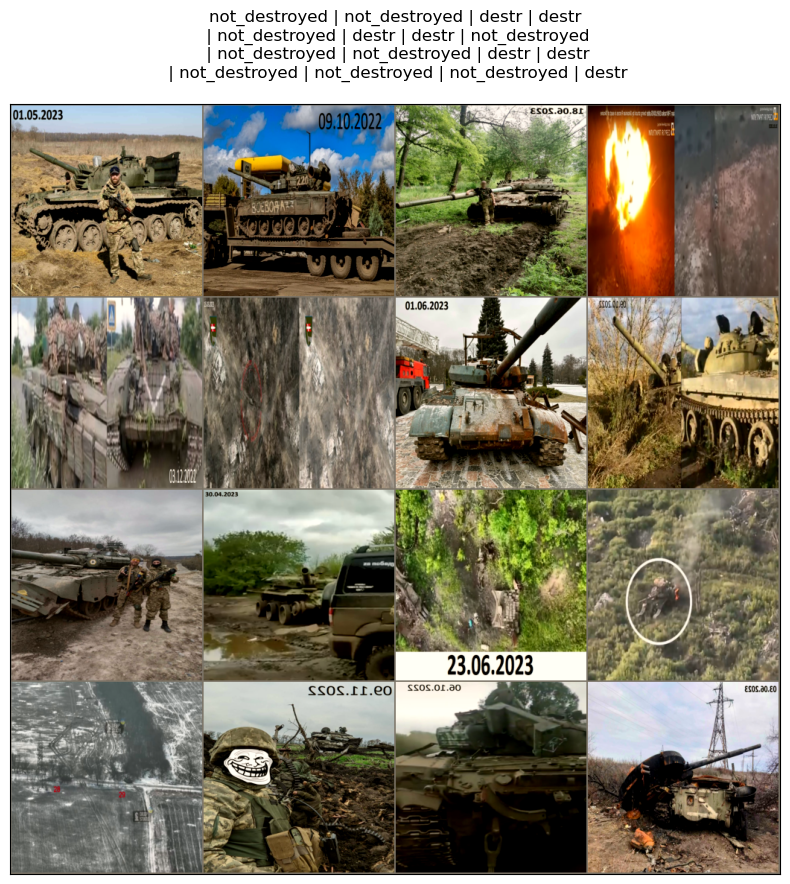

In [5]:
# Visualize the data within the dataset
import json
#with open('./data_miniplaces_modified/category_names.json', 'r') as f:
 #   class_names = json.load(f)['i2c']
#class_names = {i:name for i, name in enumerate(class_names)}
class_dir = "tank_destroyer_classifier/train"
class_names = os.listdir(class_dir)
class_names.sort()
print(class_names)
def imshow(inp, title=None, ax=None, figsize=(10, 10)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 4 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

In [60]:
# Helper function for counting number of trainable parameters.
def count_params(model):
    """
    Counts the number of trainable parameters in PyTorch.

    Args:
        model: PyTorch model.

    Returns:
        num_params: int, number of trainable parameters.
    """

    num_params = sum([item.numel() for item in model.parameters() if item.requires_grad])

    return num_params

In [58]:
class VGG(nn.Module):

    def __init__(self, features, num_classes=100, init_weights=True):
        super(VGG, self).__init__()

        # binary problem
        if num_classes == 2:
            num_classes = 1

        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((5, 5))
        self.classifier = nn.Sequential(
            nn.Linear(3200, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(512, 256, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3, inplace=False),
            nn.Linear(256, num_classes, bias=True),
            nn.Sigmoid()
        )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    

In [74]:
def train_model(model, dataloaders, criterion, optimizer, save_dir = None, num_epochs=25, model_name='MiniVGG'):

    val_acc_history = []
    val_loss_history = []

    tr_loss_history = []
    tr_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # loss and number of correct prediction for the current batch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            # TQDM has nice progress bars
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                loss_criterion = criterion
                if phase == 'train':
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  
                  preds = outputs > 0.5

                  labels = labels.unsqueeze(1)
                  labels = labels.float()
                  
                  loss = loss_criterion(outputs,labels)
                  loss.backward()
                  optimizer.step()

                else:
                  optimizer.zero_grad()
                  outputs = model(inputs)
                  preds = outputs > 0.5
                  labels = labels.unsqueeze(1)
                  labels = labels.float()
                  loss = loss_criterion(outputs,labels)


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

                if save_dir:
                    torch.save(best_model_wts, os.path.join(save_dir, model_name + '.pth'))

            # record the train/val accuracies
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                tr_acc_history.append(epoch_acc)
                tr_loss_history.append(epoch_loss)

    print('Best val Acc: {:4f}'.format(best_acc))

    return model, tr_acc_history, val_acc_history, tr_loss_history, val_loss_history

In [75]:
# 'MiniVGG-BN': [64, 'M', 128, 'M', 128, 128, 'M']

# Initialize MiniVGG-BN
features = nn.Sequential(
            nn.Conv2d(3,64,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.Conv2d(64,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),
            nn.Conv2d(128,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,(3,3),stride=(1,1),padding=(1,1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,stride=2,padding=0,dilation=1,ceil_mode=False),

          )

def make_optimizer(model):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    return optimizer

def get_loss():
    criterion =  nn.BCELoss()
    return criterion

# Number of classes in the dataset
num_classes = 2

# Number of epochs to train for
# During debugging, you can set this parameter to 1
# num_epochs = 1
# Training for 20 epochs. This will take about half an hour.
num_epochs = 20

save_dir = "oryx_weights"
os.makedirs(save_dir, exist_ok=True)

model = VGG(features, num_classes = num_classes).to(device)
optimizer = make_optimizer(model)
criterion = get_loss()


print('Number of trainable parameters {}'.format(count_params(model)))

Number of trainable parameters 2142209


In [77]:
# Train VGG
vgg_BN, tr_acc_vgg, val_acc_vgg, tr_loss_vgg, val_loss_vgg = train_model(model=model, dataloaders=dataloaders_dict, criterion=criterion, optimizer=optimizer,
           save_dir="oryx_weights", num_epochs=num_epochs, model_name='MiniVGG-BN_2')

Epoch 0/19
----------


  0%|          | 0/46 [00:00<?, ?it/s]

100%|██████████| 46/46 [01:15<00:00,  1.64s/it]


train Loss: 0.7043 Acc: 0.4951


100%|██████████| 14/14 [00:15<00:00,  1.14s/it]


valid Loss: 0.6945 Acc: 0.4597
Epoch 1/19
----------


100%|██████████| 46/46 [01:13<00:00,  1.60s/it]


train Loss: 0.6943 Acc: 0.5423


100%|██████████| 14/14 [00:12<00:00,  1.08it/s]


valid Loss: 0.6725 Acc: 0.6019
Epoch 2/19
----------


100%|██████████| 46/46 [01:13<00:00,  1.59s/it]


train Loss: 0.6877 Acc: 0.5326


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


valid Loss: 0.6684 Acc: 0.6256
Epoch 3/19
----------


100%|██████████| 46/46 [01:11<00:00,  1.56s/it]


train Loss: 0.6910 Acc: 0.5506


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


valid Loss: 0.7108 Acc: 0.4739
Epoch 4/19
----------


100%|██████████| 46/46 [01:15<00:00,  1.65s/it]


train Loss: 0.6655 Acc: 0.5978


100%|██████████| 14/14 [00:13<00:00,  1.07it/s]


valid Loss: 0.6572 Acc: 0.5972
Epoch 5/19
----------


100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


train Loss: 0.6835 Acc: 0.5603


100%|██████████| 14/14 [00:12<00:00,  1.12it/s]


valid Loss: 0.6163 Acc: 0.6825
Epoch 6/19
----------


100%|██████████| 46/46 [01:16<00:00,  1.66s/it]


train Loss: 0.6639 Acc: 0.6130


100%|██████████| 14/14 [00:12<00:00,  1.15it/s]


valid Loss: 0.6354 Acc: 0.6872
Epoch 7/19
----------


100%|██████████| 46/46 [09:23<00:00, 12.24s/it] 


train Loss: 0.6451 Acc: 0.6380


100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


valid Loss: 0.5710 Acc: 0.6825
Epoch 8/19
----------


100%|██████████| 46/46 [01:06<00:00,  1.45s/it]


train Loss: 0.6280 Acc: 0.6352


100%|██████████| 14/14 [00:12<00:00,  1.11it/s]


valid Loss: 0.6189 Acc: 0.6540
Epoch 9/19
----------


100%|██████████| 46/46 [01:04<00:00,  1.39s/it]


train Loss: 0.6490 Acc: 0.6227


100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


valid Loss: 0.5684 Acc: 0.6967
Epoch 10/19
----------


100%|██████████| 46/46 [01:03<00:00,  1.37s/it]


train Loss: 0.6248 Acc: 0.6352


100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


valid Loss: 0.5385 Acc: 0.7156
Epoch 11/19
----------


100%|██████████| 46/46 [01:02<00:00,  1.36s/it]


train Loss: 0.6033 Acc: 0.6699


100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


valid Loss: 0.5994 Acc: 0.6682
Epoch 12/19
----------


100%|██████████| 46/46 [01:04<00:00,  1.41s/it]


train Loss: 0.6137 Acc: 0.7004


100%|██████████| 14/14 [00:13<00:00,  1.03it/s]


valid Loss: 0.6552 Acc: 0.6303
Epoch 13/19
----------


100%|██████████| 46/46 [01:03<00:00,  1.39s/it]


train Loss: 0.6112 Acc: 0.6755


100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


valid Loss: 0.5474 Acc: 0.7393
Epoch 14/19
----------


100%|██████████| 46/46 [01:04<00:00,  1.41s/it]


train Loss: 0.6233 Acc: 0.6436


100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


valid Loss: 0.5679 Acc: 0.7346
Epoch 15/19
----------


100%|██████████| 46/46 [01:04<00:00,  1.40s/it]


train Loss: 0.6271 Acc: 0.6755


100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


valid Loss: 0.6022 Acc: 0.7204
Epoch 16/19
----------


100%|██████████| 46/46 [01:04<00:00,  1.41s/it]


train Loss: 0.6119 Acc: 0.6657


100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


valid Loss: 0.4968 Acc: 0.7441
Epoch 17/19
----------


100%|██████████| 46/46 [01:03<00:00,  1.37s/it]


train Loss: 0.5929 Acc: 0.6768


100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


valid Loss: 0.5785 Acc: 0.6967
Epoch 18/19
----------


100%|██████████| 46/46 [01:03<00:00,  1.39s/it]


train Loss: 0.5609 Acc: 0.7157


100%|██████████| 14/14 [00:15<00:00,  1.09s/it]


valid Loss: 0.5071 Acc: 0.7441
Epoch 19/19
----------


100%|██████████| 46/46 [01:05<00:00,  1.42s/it]


train Loss: 0.5808 Acc: 0.6949


100%|██████████| 14/14 [00:14<00:00,  1.03s/it]


valid Loss: 0.5160 Acc: 0.7346
Best val Acc: 0.744076


In [156]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

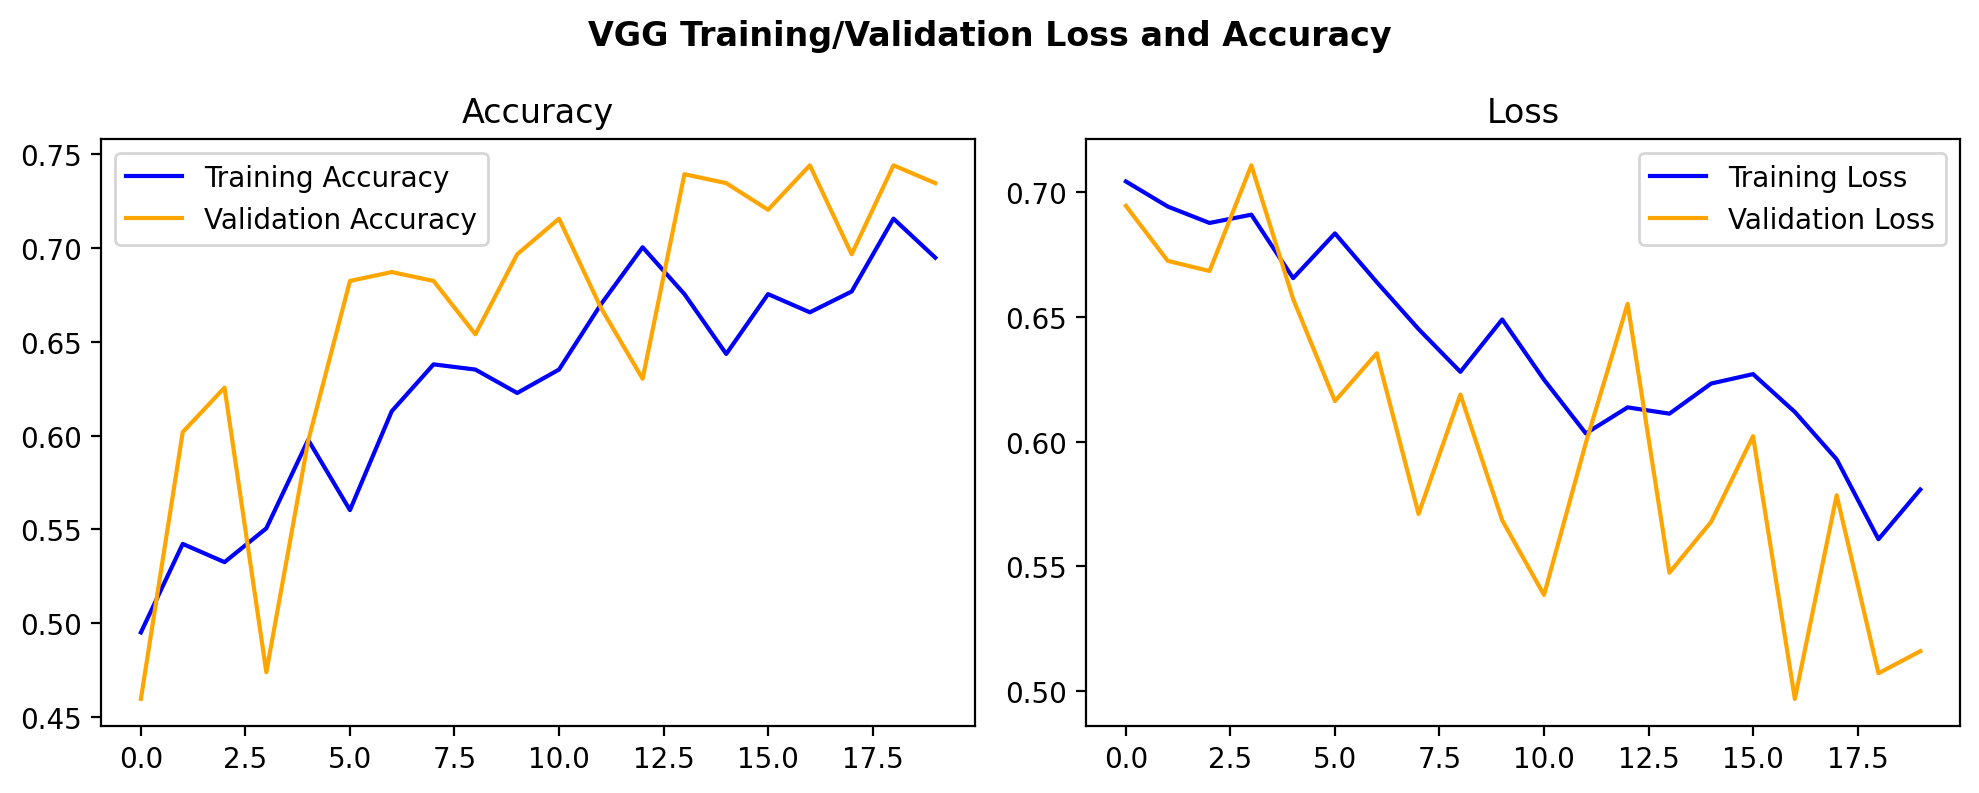

In [78]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot on the first subplot
axes[0].plot(tr_acc_vgg, label='Training Accuracy', color='blue')
axes[0].plot(val_acc_vgg, label='Validation Accuracy', color='orange')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot on the second subplot
axes[1].plot(tr_loss_vgg, label='Training Loss', color='blue')
axes[1].plot(val_loss_vgg, label='Validation Loss', color='orange')
axes[1].set_title('Loss')
axes[1].legend()

fig.suptitle("VGG Training/Validation Loss and Accuracy", fontweight = 'bold')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

fig.savefig('vgg_training_validation_loss_accuracy.png')

In [6]:
resnet18 = models.resnet18(pretrained=True)

load_checkpoint = False

if load_checkpoint:
    resnet18 = models.resnet18(pretrained=False)
    resnet18.load_state_dict(torch.load('oryx_weights/resnet18_tank_classification.pth'))

# Freeze all layers except the final fully connected layer
for param in resnet18.parameters():
    param.requires_grad = False

# Modify the last layer for binary classification
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)  # Assuming binary classification, change '2' based on your classes

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = resnet18.to(device)

train_loader = dataloaders_dict['train']

trn_loss = []
trn_accuracy = []
val_loss = []
val_accuracy = []


for epoch in range(num_epochs):
    if epoch % 5 == 0:
        continue_train = input("Continue Train? (y/n): ")
        if continue_train == 'n':
            break

    resnet18.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_loss = running_loss / len(train_loader)
    accuracy_train = correct_train / total_train

    trn_loss.append(average_loss)
    trn_accuracy.append(accuracy_train)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss (Train): {average_loss:.4f}, Accuracy (Train): {accuracy_train * 100:.2f}%")

    # on validation set
    resnet18.eval()
    correct = 0
    total = 0
    loss_valid = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders_dict['valid']):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            loss_valid += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_accuracy = correct / total
    valid_loss = loss_valid / len(dataloaders_dict['valid'])

    val_accuracy.append(valid_accuracy)
    val_loss.append(valid_loss)

    # save model if max validation accuracy
    if valid_accuracy > max(val_accuracy):
        torch.save(resnet18.state_dict(), 'oryx_weights/resnet18_tank_classification_max_accuracy.pth')

    print(f"Loss (Valid): {valid_loss:.4f}, Accuracy (Valid): {valid_accuracy * 100:.2f}%")


torch.save(resnet18.state_dict(), 'oryx_weights/resnet18_tank_classification.pth')

c:\Users\randymi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\randymi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 46/46 [00:19<00:00,  2.37it/s]


Epoch 1/100, Loss (Train): 0.6290, Accuracy (Train): 63.52%


100%|██████████| 14/14 [00:08<00:00,  1.74it/s]


Loss (Valid): 0.5535, Accuracy (Valid): 73.46%


100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 2/100, Loss (Train): 0.5962, Accuracy (Train): 68.52%


100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


Loss (Valid): 0.5146, Accuracy (Valid): 78.20%


100%|██████████| 46/46 [00:18<00:00,  2.50it/s]


Epoch 3/100, Loss (Train): 0.5558, Accuracy (Train): 72.40%


100%|██████████| 14/14 [00:07<00:00,  1.77it/s]


Loss (Valid): 0.4669, Accuracy (Valid): 82.94%


100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 4/100, Loss (Train): 0.5343, Accuracy (Train): 73.65%


100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Loss (Valid): 0.4644, Accuracy (Valid): 83.41%


100%|██████████| 46/46 [00:18<00:00,  2.49it/s]


Epoch 5/100, Loss (Train): 0.5171, Accuracy (Train): 74.48%


100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Loss (Valid): 0.5741, Accuracy (Valid): 69.67%


100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Epoch 6/100, Loss (Train): 0.5147, Accuracy (Train): 73.79%


100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


Loss (Valid): 0.4507, Accuracy (Valid): 81.99%


100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 7/100, Loss (Train): 0.4878, Accuracy (Train): 76.14%


100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Loss (Valid): 0.4212, Accuracy (Valid): 81.99%


100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 8/100, Loss (Train): 0.5087, Accuracy (Train): 76.42%


100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Loss (Valid): 0.4705, Accuracy (Valid): 79.62%


100%|██████████| 46/46 [00:17<00:00,  2.59it/s]


Epoch 9/100, Loss (Train): 0.5143, Accuracy (Train): 72.54%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.5252, Accuracy (Valid): 72.99%


100%|██████████| 46/46 [00:18<00:00,  2.53it/s]


Epoch 10/100, Loss (Train): 0.5093, Accuracy (Train): 74.62%


100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Loss (Valid): 0.5328, Accuracy (Valid): 72.51%


100%|██████████| 46/46 [00:18<00:00,  2.48it/s]


Epoch 11/100, Loss (Train): 0.4900, Accuracy (Train): 74.34%


100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


Loss (Valid): 0.4165, Accuracy (Valid): 83.41%


100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 12/100, Loss (Train): 0.4426, Accuracy (Train): 79.06%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.5004, Accuracy (Valid): 77.73%


100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 13/100, Loss (Train): 0.4374, Accuracy (Train): 78.92%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.4960, Accuracy (Valid): 74.88%


100%|██████████| 46/46 [00:18<00:00,  2.55it/s]


Epoch 14/100, Loss (Train): 0.4572, Accuracy (Train): 79.06%


100%|██████████| 14/14 [00:08<00:00,  1.68it/s]


Loss (Valid): 0.4952, Accuracy (Valid): 75.36%


100%|██████████| 46/46 [00:18<00:00,  2.49it/s]


Epoch 15/100, Loss (Train): 0.4459, Accuracy (Train): 78.09%


100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Loss (Valid): 0.4715, Accuracy (Valid): 76.78%


100%|██████████| 46/46 [00:19<00:00,  2.39it/s]


Epoch 16/100, Loss (Train): 0.4902, Accuracy (Train): 77.12%


100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


Loss (Valid): 0.3978, Accuracy (Valid): 82.46%


100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 17/100, Loss (Train): 0.4405, Accuracy (Train): 78.78%


100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Loss (Valid): 0.3883, Accuracy (Valid): 85.31%


100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 18/100, Loss (Train): 0.4375, Accuracy (Train): 79.61%


100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


Loss (Valid): 0.4169, Accuracy (Valid): 82.46%


100%|██████████| 46/46 [00:19<00:00,  2.42it/s]


Epoch 19/100, Loss (Train): 0.3969, Accuracy (Train): 82.66%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.4457, Accuracy (Valid): 80.09%


100%|██████████| 46/46 [00:18<00:00,  2.45it/s]


Epoch 20/100, Loss (Train): 0.4549, Accuracy (Train): 79.20%


100%|██████████| 14/14 [00:08<00:00,  1.75it/s]


Loss (Valid): 0.3823, Accuracy (Valid): 85.78%


100%|██████████| 46/46 [00:17<00:00,  2.70it/s]


Epoch 21/100, Loss (Train): 0.4049, Accuracy (Train): 81.97%


100%|██████████| 14/14 [00:08<00:00,  1.69it/s]


Loss (Valid): 0.4354, Accuracy (Valid): 80.09%


100%|██████████| 46/46 [00:19<00:00,  2.33it/s]


Epoch 22/100, Loss (Train): 0.4640, Accuracy (Train): 79.06%


100%|██████████| 14/14 [00:08<00:00,  1.63it/s]


Loss (Valid): 0.3935, Accuracy (Valid): 84.36%


100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 23/100, Loss (Train): 0.4423, Accuracy (Train): 78.09%


100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


Loss (Valid): 0.4295, Accuracy (Valid): 76.78%


100%|██████████| 46/46 [00:18<00:00,  2.48it/s]


Epoch 24/100, Loss (Train): 0.4362, Accuracy (Train): 79.20%


100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


Loss (Valid): 0.3508, Accuracy (Valid): 86.73%


100%|██████████| 46/46 [00:18<00:00,  2.47it/s]


Epoch 25/100, Loss (Train): 0.4026, Accuracy (Train): 81.14%


100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Loss (Valid): 0.4428, Accuracy (Valid): 80.57%


100%|██████████| 46/46 [00:18<00:00,  2.54it/s]


Epoch 26/100, Loss (Train): 0.4668, Accuracy (Train): 77.67%


100%|██████████| 14/14 [00:07<00:00,  1.80it/s]


Loss (Valid): 0.4160, Accuracy (Valid): 83.41%


100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 27/100, Loss (Train): 0.3981, Accuracy (Train): 84.05%


100%|██████████| 14/14 [00:07<00:00,  1.76it/s]


Loss (Valid): 0.3765, Accuracy (Valid): 83.89%


100%|██████████| 46/46 [00:18<00:00,  2.43it/s]


Epoch 28/100, Loss (Train): 0.4814, Accuracy (Train): 77.67%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.3517, Accuracy (Valid): 85.78%


100%|██████████| 46/46 [00:18<00:00,  2.45it/s]


Epoch 29/100, Loss (Train): 0.4085, Accuracy (Train): 80.72%


100%|██████████| 14/14 [00:07<00:00,  1.75it/s]


Loss (Valid): 0.3375, Accuracy (Valid): 88.15%


100%|██████████| 46/46 [00:18<00:00,  2.44it/s]


Epoch 30/100, Loss (Train): 0.4002, Accuracy (Train): 82.52%


100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


Loss (Valid): 0.3451, Accuracy (Valid): 89.10%


100%|██████████| 46/46 [00:17<00:00,  2.66it/s]


Epoch 31/100, Loss (Train): 0.3587, Accuracy (Train): 83.77%


100%|██████████| 14/14 [00:07<00:00,  1.89it/s]


Loss (Valid): 0.3905, Accuracy (Valid): 84.83%


100%|██████████| 46/46 [00:17<00:00,  2.62it/s]


Epoch 32/100, Loss (Train): 0.3993, Accuracy (Train): 83.08%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.3561, Accuracy (Valid): 84.83%


100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 33/100, Loss (Train): 0.3893, Accuracy (Train): 82.80%


100%|██████████| 14/14 [00:07<00:00,  1.86it/s]


Loss (Valid): 0.3979, Accuracy (Valid): 82.46%


100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 34/100, Loss (Train): 0.4119, Accuracy (Train): 80.58%


100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Loss (Valid): 0.2986, Accuracy (Valid): 89.57%


100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 35/100, Loss (Train): 0.4167, Accuracy (Train): 80.58%


100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Loss (Valid): 0.3387, Accuracy (Valid): 85.78%


100%|██████████| 46/46 [00:16<00:00,  2.73it/s]


Epoch 36/100, Loss (Train): 0.3797, Accuracy (Train): 81.97%


100%|██████████| 14/14 [00:07<00:00,  1.91it/s]


Loss (Valid): 0.3364, Accuracy (Valid): 85.78%


100%|██████████| 46/46 [00:17<00:00,  2.61it/s]


Epoch 37/100, Loss (Train): 0.4044, Accuracy (Train): 82.66%


100%|██████████| 14/14 [00:07<00:00,  1.84it/s]


Loss (Valid): 0.3511, Accuracy (Valid): 84.83%


100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 38/100, Loss (Train): 0.3952, Accuracy (Train): 82.25%


100%|██████████| 14/14 [00:07<00:00,  1.81it/s]


Loss (Valid): 0.3379, Accuracy (Valid): 87.20%


100%|██████████| 46/46 [00:18<00:00,  2.52it/s]


Epoch 39/100, Loss (Train): 0.4054, Accuracy (Train): 81.00%


100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Loss (Valid): 0.3942, Accuracy (Valid): 84.36%


100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 40/100, Loss (Train): 0.4089, Accuracy (Train): 81.28%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.3285, Accuracy (Valid): 87.68%


100%|██████████| 46/46 [00:18<00:00,  2.46it/s]


Epoch 41/100, Loss (Train): 0.3976, Accuracy (Train): 81.00%


100%|██████████| 14/14 [00:07<00:00,  1.85it/s]


Loss (Valid): 0.3138, Accuracy (Valid): 90.05%


100%|██████████| 46/46 [00:17<00:00,  2.60it/s]


Epoch 42/100, Loss (Train): 0.3685, Accuracy (Train): 85.02%


100%|██████████| 14/14 [00:07<00:00,  1.87it/s]


Loss (Valid): 0.3065, Accuracy (Valid): 87.68%


100%|██████████| 46/46 [00:17<00:00,  2.58it/s]


Epoch 43/100, Loss (Train): 0.4281, Accuracy (Train): 79.61%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.4305, Accuracy (Valid): 81.52%


100%|██████████| 46/46 [00:17<00:00,  2.56it/s]


Epoch 44/100, Loss (Train): 0.4152, Accuracy (Train): 81.83%


100%|██████████| 14/14 [00:07<00:00,  1.83it/s]


Loss (Valid): 0.3177, Accuracy (Valid): 90.52%


100%|██████████| 46/46 [00:17<00:00,  2.57it/s]


Epoch 45/100, Loss (Train): 0.3568, Accuracy (Train): 83.77%


100%|██████████| 14/14 [00:07<00:00,  1.79it/s]


Loss (Valid): 0.3553, Accuracy (Valid): 85.78%


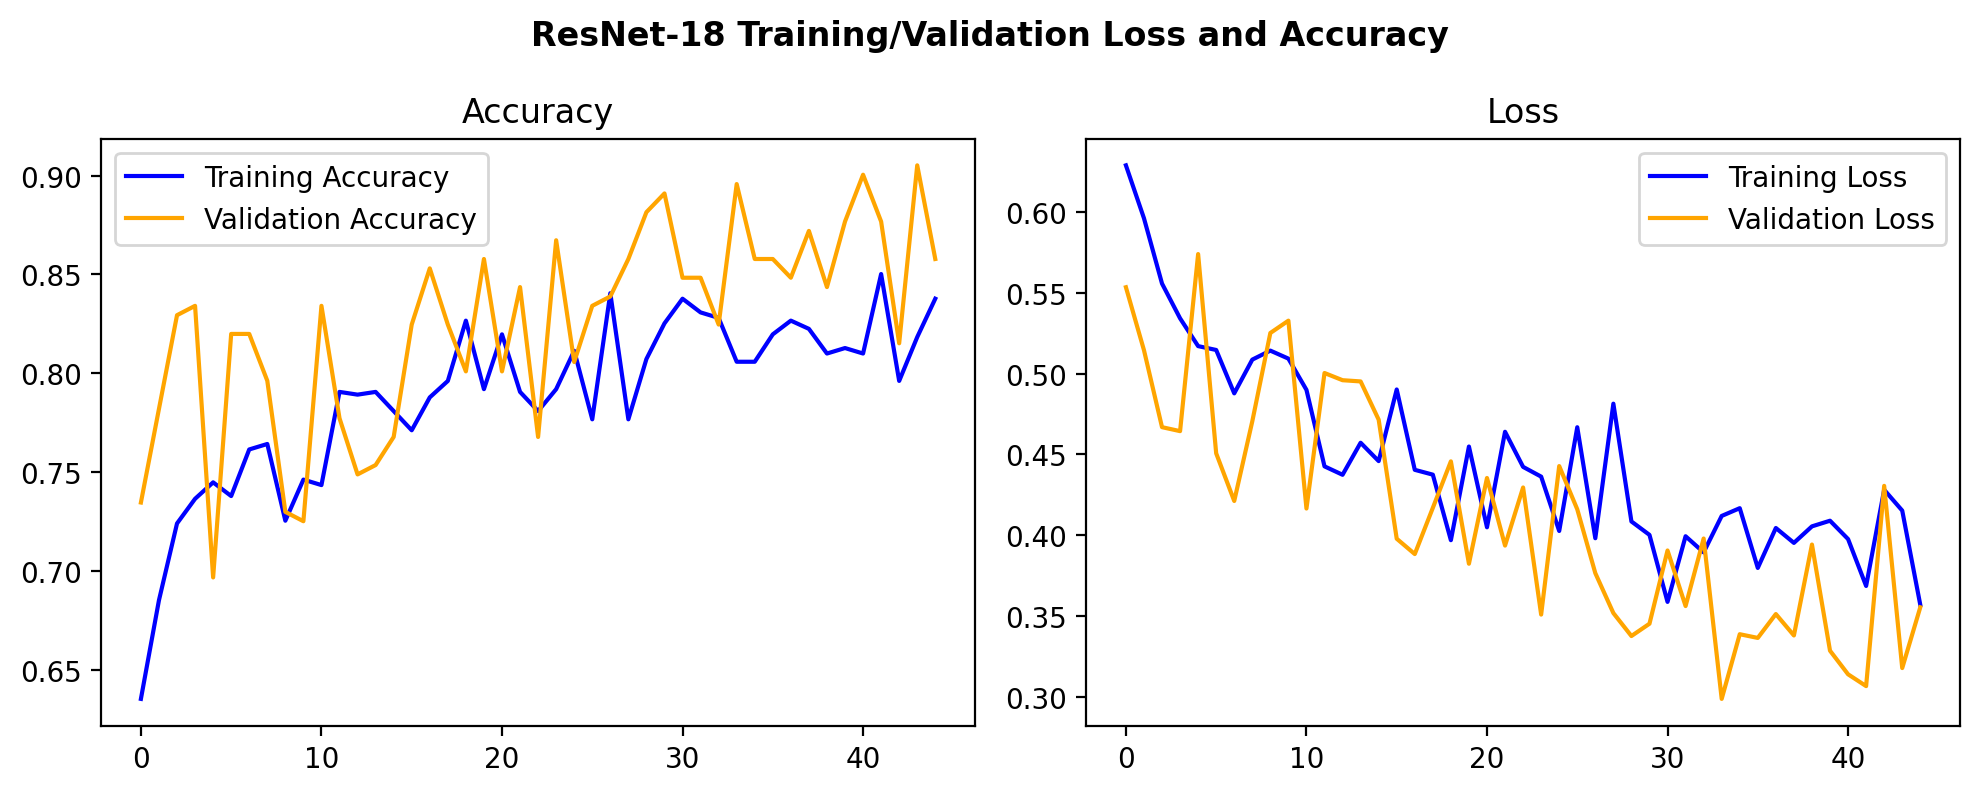

In [12]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import seaborn as sns

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot on the first subplot
axes[0].plot(trn_accuracy, label='Training Accuracy', color='blue')
axes[0].plot(val_accuracy, label='Validation Accuracy', color='orange')
axes[0].set_title('Accuracy')
axes[0].legend()

# Plot on the second subplot
axes[1].plot(trn_loss, label='Training Loss', color='blue')
axes[1].plot(val_loss, label='Validation Loss', color='orange')
axes[1].set_title('Loss')
axes[1].legend()

fig.suptitle("ResNet-18 Training/Validation Loss and Accuracy", fontweight = 'bold')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

fig.savefig('resnet18_training_validation_loss_accuracy.png')

c:\Users\randymi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\randymi\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor(-2.0918)


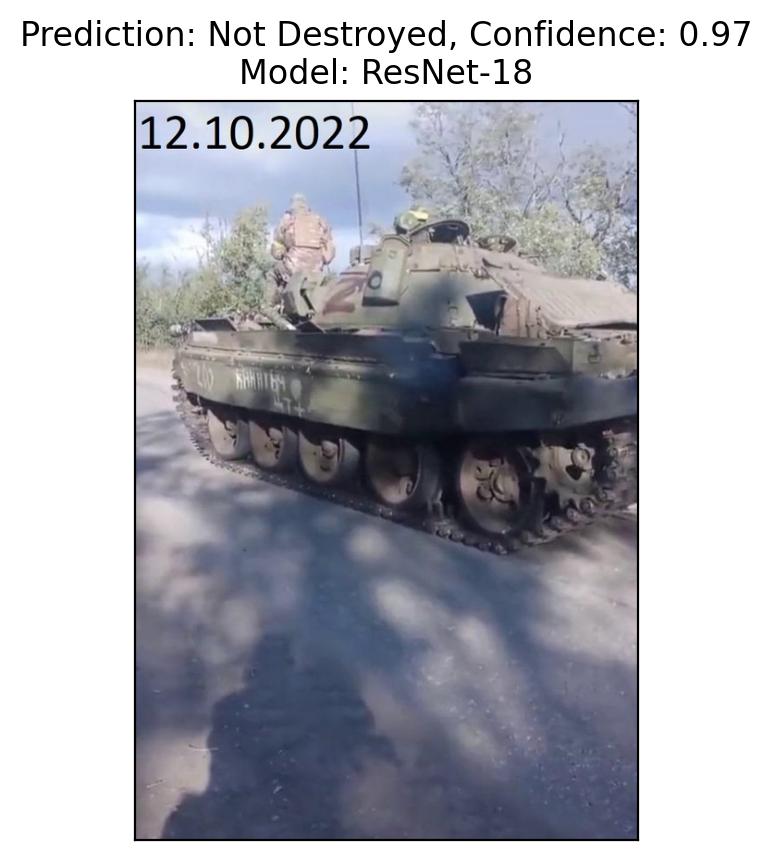

('Not Destroyed', 0.9707674384117126)

In [89]:
# load resnet_tank_classifier

tank_classifier_resnet = models.resnet18(pretrained=False)
num_features = tank_classifier_resnet.fc.in_features
tank_classifier_resnet.fc = nn.Linear(num_features, 2)

tank_classifier_resnet.load_state_dict(torch.load('oryx_weights/resnet18_tank_classification.pth'))

tank_classifier_resnet.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Update with your model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean = np.array([0.485, 0.456, 0.406]), 
                         std = np.array([0.229, 0.224, 0.225]))  # Update with your model's normalization
])

# load VGG tank classifier

tank_classifier_vgg = VGG(features, num_classes = num_classes).to(device)
tank_classifier_vgg.load_state_dict(torch.load('oryx_weights/MiniVGG-BN.pth'))
tank_classifier_vgg.eval()



tensor(0.7803)


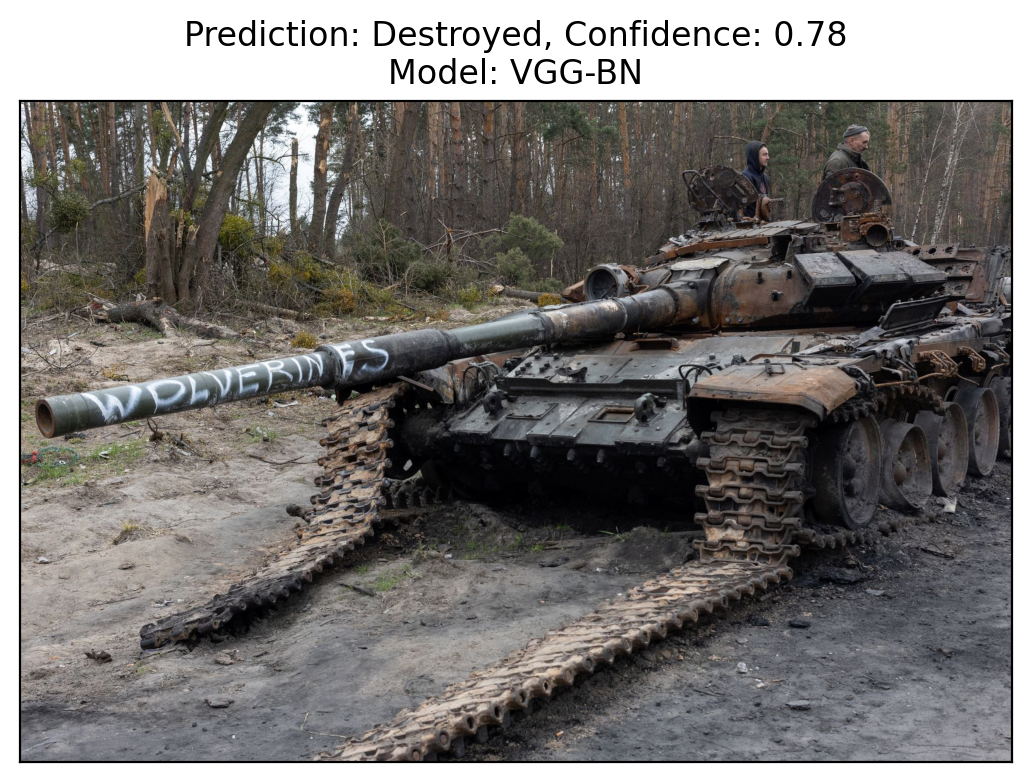

('Destroyed', 0.7802774310112)

In [97]:

def display_img(im, prediction, confidence, model_name):
    plt.imshow(im)
    plt.title(f"Prediction: {prediction}, Confidence: {confidence:.2f}\nModel: {model_name}")
    plt.xticks([])
    plt.yticks([])
    plt.show()

def predict_image(image_path, model, transform, show_img = True):
    # returns class and confidence

    # check if image_path is url or not

    if image_path.startswith('http'):
        response = re.get(image_path)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
        else:
            print(f"Failed to fetch image. Status code: {response.status_code}")
            return 0
    else:
        image = Image.open(image_path)

    input_image = transform(image).unsqueeze(0)  # Add batch dimension

    # Forward pass through the model
    with torch.no_grad():
        output = model(input_image)

    print(output[0][0])

    # for resnet which has output size of 2
    if output.size(1) > 1:
        _, predicted = torch.max(output.data, 1)
        prediction = ["Destroyed", "Not Destroyed"][predicted.item()]
        confidence = nn.Softmax(dim = 1)(output).max().item()
        display_img(image, prediction, confidence, model_name = "ResNet-18")
        return prediction, confidence
    
    # for vgg which has output size of 1
    elif output.size(1) == 1:
        prediction = "Destroyed" if output[0][0] > 0.5 else "Not Destroyed"
        confidence = output[0][0].item() if output[0][0] > 0.5 else 1 - output[0][0].item()
        display_img(image, prediction, confidence, model_name = "VGG-BN")
        return prediction, confidence

    else:
        return "Error, invalid model output", 0


predict_image('https://www.reuters.com/resizer/Ar6j-b780kmkghG482ZsTEpap18=/1920x0/filters:quality(80)/archive-images.prod.global.a201836.reutersmedia.net/2022/04/26/2022-04-26T181611Z_18524_MRPRC21RT9JN1RJ_RTRMADP_0_UKRAINE-CRISIS.JPG', tank_classifier_vgg, transform)